# **Assignment #3 and #4**
Due date: **Friday December 5th, 11:59pm**

Instructor: Bill Tilford (bill.tilford@sauder.ubc.ca)


## **Background**

This assignment is divided into two parts.

**Part I** (Assignment #3)

This is an exercise in applying the most simple (and naïve) strategies, under the three
categories we have studied: SAA, TAA and IAA. This exercise will demonstrate how
difficult TAA and IAA strategies may be to implement and profit from.

The data in this part are returns on quarterly basis. We have the percentage quarterly returns on a 3-month maturity Canadian T-bill and the percentage quarterly returns on the TSX Canadian stock index for 35 years, from 1990 Q1 through 2024 Q4. In all our strategy tests we calculate the annualized returns and standard diviations by multipying the quarterly returns by 4 and the quarterly standard deviations by $\sqrt{4}=2$.

**Part II** (Assignment #4)

Part II applies Fama French factors to 5 BlackRock ETF funds. In this part, you will learn how to assess the style of an investment product like. In particular, you will asseess how the return on BlackRock "Style ETFs" load on the Fama and French factors.

The data in this part is available on a monthly basis, from Apr 2013 to Jan 2025.



## **Part I: SAA, TAA, and IAA**

### Data and preliminary functions

We fistly check if required packages are installed.

In [1]:
# run this to check if required packages are installed
import subprocess
import sys

def install_packages(packages):
    """
    Ensure that all specified packages are installed. If a package is not installed,
    it will be installed automatically.

    Args:
        packages (list): A list of package names to ensure are installed.

    Returns:
        None
    """
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        else:
            print(f"{package} is already installed.")

required_packages = [
    "numpy",
    "scipy",
    "pandas",
    "wrds",
    "datetime",
    "statsmodels",
    "matplotlib",
    "pathlib",
    "pandas_datareader",
    "scikit-learn",
    "warnings",
    "itertools",
    "joblib",
    "PyPortfolioOpt",
    "seaborn",
    "cvxpy",
    "pandas_datareader",
    "certifi",
]
install_packages(required_packages)

numpy is already installed.
scipy is already installed.
pandas is already installed.
Installing wrds...
datetime is already installed.
statsmodels is already installed.
matplotlib is already installed.
pathlib is already installed.
pandas_datareader is already installed.
Installing scikit-learn...
warnings is already installed.
itertools is already installed.
joblib is already installed.
Installing PyPortfolioOpt...
seaborn is already installed.
cvxpy is already installed.
pandas_datareader is already installed.
certifi is already installed.


We then import required packages.

In [2]:
#******************************************************************************
#  Run the following code to import the needed packages
#******************************************************************************
import wrds
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
import pandas_datareader as pdr

import certifi
import ssl
import urllib.request

# handle warnings in wrds
import warnings
warnings.filterwarnings("ignore")

# Create unverified context
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

Then, we enter credentials and connect to WRDS.
In the following code, update your user name to connect to WRDS:

In [3]:
# WRDS connection
# update this line wrds_username = 'your_username'
wrds_username = ''

try:
    print("Establishing connection to WRDS database...")
    params = {
        'wrds_hostname': wrds.sql.WRDS_POSTGRES_HOST,
        'wrds_port': wrds.sql.WRDS_POSTGRES_PORT,
        'wrds_dbname': wrds.sql.WRDS_POSTGRES_DB,
        'wrds_username': wrds_username,
        'wrds_connect_args': wrds.sql.WRDS_CONNECT_ARGS,
    }

    conn = wrds.Connection(autoconnect=True, **params)
    print("Successfully connected to WRDS database.")
except Exception as e:
    print(f"Failed to connect to WRDS database: {e}")

Establishing connection to WRDS database...
Enter your WRDS username [root]:jennycc
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Successfully connected to WRDS database.


Now we have connected to WRDS and we can query data tables from WRDS. We load Fama-French 4 factors from WRDS. Fama-French 4 factors are used in Part II.

We firstly set the start date and end date of the sample data.

In [4]:
# define start date and end date of fama-french factors
start_date_ff = "07/01/1963"
end_date_ff = "02/01/2025"

# load ff factors from wrds
ff4_factors_monthly = conn.raw_sql(
    f"""SELECT date, mktrf, smb, hml, umd, rf
    FROM ff_all.factors_monthly WHERE date BETWEEN '{start_date_ff}' AND '{end_date_ff}'
    """,
    date_cols=['date']
)

# add year, month, and rename mktrf to mkt_excess
ff4_factors_monthly = (ff4_factors_monthly.assign(year=lambda x: pd.DatetimeIndex(x["date"]).year)
                                          .assign(month=lambda x: pd.DatetimeIndex(x["date"]).month)
                                          .rename(columns={"mktrf": "mkt_excess"})
                                          .rename(columns={"umd": "mom"})
)

# arrange the column as follows: month, rf, mkt_excess, smb, hml, mom and format to numeric
ff4_factors_monthly = ff4_factors_monthly[["date", "rf", "mkt_excess", "smb", "hml", "mom"]]
ff4_factors_monthly[["rf", "mkt_excess", "smb", "hml", "mom"]]  = ff4_factors_monthly[["rf", "mkt_excess", "smb", "hml", "mom"]].to_numpy(dtype=np.float64)

ff4_factors_monthly

,date,rf,mkt_excess,smb,hml,mom
0,1963-07-01,0.0027,-0.0039,-0.0057,-0.0081,0.0101
1,1963-08-01,0.0025,0.0508,-0.0095,0.0170,0.0100
2,1963-09-01,0.0027,-0.0157,-0.0025,0.0000,0.0012
3,1963-10-01,0.0029,0.0254,-0.0057,-0.0004,0.0313
4,1963-11-01,0.0027,-0.0086,-0.0116,0.0173,-0.0078
...,...,...,...,...,...,...
735,2024-10-01,0.0039,-0.0100,-0.0099,0.0086,0.0300
736,2024-11-01,0.0040,0.0649,0.0446,0.0015,0.0100
737,2024-12-01,0.0037,-0.0317,-0.0271,-0.0300,-0.0030
738,2025-01-01,0.0037,0.0280,-0.0197,0.0163,0.0096


We run the following code to read Canada 3-month T-bill rate and the TSX index return data from Github page.

In [5]:
#******************************************************************************
#Run the following code to read Data from a github repository
#Quarterly returns on the 3-month T-bill, the TSX from 1990 Q1 to 2024 Q4
#******************************************************************************

csv_returns = 'https://raw.githubusercontent.com/BillTilford/COMM475/main/AssetClass_Returns_Data_Dec2024.txt'
# raw_data = pd.read_csv(csv_returns, header = None, delim_whitespace=True)
with urllib.request.urlopen(csv_returns, context=ctx) as u:
    raw_data = pd.read_csv(u, header = None, delim_whitespace=True)

raw_data.columns = ['Qtr', 'End of Yr', '3mo TB', 'TSX']

# The returns are in percentage, we convert percentages to fractions
raw_data['3mo TB'] = raw_data['3mo TB'] / 100
raw_data['TSX'] = raw_data['TSX'] / 100

# round the data to 4 decimal places
raw_data = raw_data.round(4)


# Let's take a peak at the data
raw_data.head()

,Qtr,End of Yr,3mo TB,TSX
0,1990Q1,0.25,0.0308,-0.0833
1,1990Q2,0.50,0.0336,-0.0262
2,1990Q3,0.75,0.0342,-0.1086
3,1990Q4,1.00,0.0312,0.0311
4,1991Q1,1.25,0.0290,0.0733


### **Section 1: SAA**

### Warm-up exercise

(a) Create a copy called `data` of the `raw_data` database by executing the following command: `data = raw_data.copy()`

(b) In the `data` database, add a column labeled `W_s=0.5` that contains the value 0.5 for each quarter in the database. This column represents the portfolio weight in the TSX. This is an SAA strategy: constant portfolio weights overtime

(c) Add a column called `return W_s=0.5` that reports the return on the portfolio that invests $W_S= 50\%$ in the TSX and $W_c=1-W_s$ in the T-bill

(d) Compute the quarterly mean and volatility of the portfolio return

(e) Compute the annual mean and volatility of the portfolio return

In [6]:
#******************************************************************************
# answer for warm-up exercise
#******************************************************************************

# (a)
data = raw_data.copy()

# (b)  In the `data` database, add a column labeled `W_s=0.5` that contains the value 0.5 for each quarter in the databse.
data['W_s=0.5'] = 0.5


# (c) Add a column called `return W_s=0.5` that reports the return on the portfolio that invests $W_S= 50%$ in the TSX and $W_c=1-W_s$ in the T-bill
data['return W_s=0.5'] = data['W_s=0.5'] * data['TSX'] + (1 - data['W_s=0.5']) * data['3mo TB']


# (d) Compute the quarterly mean and volatility of the portfolio return
mean = data['return W_s=0.5'].mean()
volatility = data['return W_s=0.5'].std()


# (e) Compute the annual mean and volatility of the portfolio return
annual_mean = mean * 4
annual_volatility = volatility * np.sqrt(4)


# Print the results of the calculations in percentage
print(f"The quarterly mean of the portfolio return is {mean * 100:.2f}%")
print(f"The quarterly volatility of the portfolio return is {volatility * 100:.2f}%")
print(f"The annual mean of the portfolio return is {annual_mean * 100:.2f}%")
print(f"The annual volatility of the portfolio return is {annual_volatility * 100:.2f}%")

# Let's take a peak at the data
data.head()

The quarterly mean of the portfolio return is 1.23%
The quarterly volatility of the portfolio return is 3.84%
The annual mean of the portfolio return is 4.93%
The annual volatility of the portfolio return is 7.69%


,Qtr,End of Yr,3mo TB,TSX,W_s=0.5,return W_s=0.5
0,1990Q1,0.25,0.0308,-0.0833,0.5,-0.02625
1,1990Q2,0.50,0.0336,-0.0262,0.5,0.00370
2,1990Q3,0.75,0.0342,-0.1086,0.5,-0.03720
3,1990Q4,1.00,0.0312,0.0311,0.5,0.03115
4,1991Q1,1.25,0.0290,0.0733,0.5,0.05115


### Question 1

Repeat the exercise in the ``warm up question" above for the following SAA weights

$W_{c}$	| $W_{s}$ |
--------|---------|
1.00	|0.00     |
0.75	|0.25     |
0.50	|0.50     |
0.25	|0.75     |
0.00	|1.00     |


That is, add a column with the weights, one column with the return and then compute the quarterly and annual mean and volatiltiy of each SAA strategy.





In [7]:
data = raw_data.copy()

# SAA weights: Wc = 1 - Ws
weights_ws = [0.00, 0.25, 0.50, 0.75, 1.00]

results = []

for w in weights_ws:
    # Create column names
    col_w = f"W_s={w}"
    col_ret = f"return W_s={w}"

    # Add weight column
    data[col_w] = w

    # Portfolio return
    data[col_ret] = w * data["TSX"] + (1 - w) * data["3mo TB"]

    # Quarterly stats
    mean_q = data[col_ret].mean()
    vol_q = data[col_ret].std()

    # Annualized stats
    mean_a = mean_q * 4
    vol_a = vol_q * np.sqrt(4)

    # Store results
    results.append([w, 1-w, mean_q, vol_q, mean_a, vol_a])

# Results
results_df = pd.DataFrame(
    results,
    columns=[
        "W_s (TSX)", "W_c (T-bill)",
        "Quarterly Mean", "Quarterly Volatility",
        "Annual Mean", "Annual Volatility"
    ]
)

print("SAA Performance for All Weights:")
results_df.style.format({
    "Quarterly Mean": "{:.4f}",
    "Quarterly Volatility": "{:.4f}",
    "Annual Mean": "{:.4f}",
    "Annual Volatility": "{:.4f}"
})


SAA Performance for All Weights:


,W_s (TSX),W_c (T-bill),Quarterly Mean,Quarterly Volatility,Annual Mean,Annual Volatility
0,0.000000,1.000000,0.0084,0.0073,0.0337,0.0146
1,0.250000,0.750000,0.0104,0.0197,0.0415,0.0394
2,0.500000,0.500000,0.0123,0.0384,0.0493,0.0769
3,0.750000,0.250000,0.0143,0.0577,0.0571,0.1153
4,1.000000,0.000000,0.0162,0.0770,0.0649,0.1540


### Question 2

**Part (a)**.  Consider the asset mix matrix below, which is the same as the asset mix matrix in Question 1:

$W_{c}$	| $W_{s}$ |
--------|---------|
1.00	|0.00     |
0.75	|0.25     |
0.50	|0.50     |
0.25	|0.75     |
0.00	|1.00     |

Suppose you follow this SAA strategy with rebalancing of the weights at the start of each quarter by returning to the original weights ($W_{c}$,$W_{s}$) for ```50``` years. If you start with $V_{0}$ dollars of portfolio value (wealth) of $V_{0} = 1,000$.

The expected wealth after ```50``` years is:

$$E[V] = V_{0}*(1+E[r])^{50};$$

where $E[r]$ is the mean annualized expected portfolio return you calculated based on the historical data from  1990 Q1 to 2024 Q4.

The standard deviation of the ending wealth $\sigma[V]$ is:

$$\sigma[V]= V_{0}*\sigma_{y}[V]* \sqrt {50};$$

where $\sigma_{y}[V]$ is the annualized portfolio standard deviation you calculated based on the historical data from 1990 Q1 to 2024 Q4.

The 95% confidence bound for the ending wealth $V$ are $L(V) = E[V] - 2*\sigma[V]$ and  $H(V) = E[V] + 2*\sigma[V]$.

For the five SAA weights listed in the table above, calculate the following quantities:

* (i) $E[V]$
* (ii) $\sigma[V]$
* (iii) Lower outcome $L(V)$
* (iv) Higher outcome $H(V)$
* (v) Downside potential  $\frac{L(V)}{E(V)}-1$

Comment on the effect of a more/less risky SAA strategy on expected future wealth. Of the five possible weights ($W_{c}$,$W_{s}$), which weight pair would you choose? Why?
Please note that depending on the investment objective, the weight pair chosen may be different.

**Part (b)** Repeat the analysis in Part (a) for the case of an investment horizon of only 5 years. How would your conclusions change when the investment horizon is only 5 years?


**Part (c)** Comparing the results in Part (a) and (b), discuss why some investors prefer "target-dated funds" where in the investor's early life stage investors mostly invest in stocks (with little allocation in bonds) but the weights switch from mostly stocks to mostly bonds as investors approach their retirements.

**Part(a)**

In [8]:
print(f"Part (a)")

# Inputs
V0 = 1000.0
T = 50
weights_ws = [0.00, 0.25, 0.50, 0.75, 1.00]


def ann_stats(series):
    mu_ann = 4 * series.mean()
    sigma_ann = np.sqrt(4) * series.std()
    return mu_ann, sigma_ann

def wealth_metrics(mu_ann, sigma_ann, T, V0):
    EV   = V0 * (1 + mu_ann)**T
    sdV  = V0 * sigma_ann * np.sqrt(T)
    L    = EV - 2*sdV
    H    = EV + 2*sdV
    down = L/EV - 1
    return EV, sdV, L, H, down

rows = []
for w in weights_ws:
    mu_ann, sigma_ann = ann_stats(data[f"return W_s={w}"])
    EV, sdV, L, H, down = wealth_metrics(mu_ann, sigma_ann, T, V0)
    rows.append({
        "W_s (TSX)": w,
        "W_c (T-bill)": 1 - w,
        "Annual Mean (μ)": mu_ann,
        "Annual Vol (σ)": sigma_ann,
        "E[V]": EV,
        "σ[V]": sdV,
        "L(V)": L,
        "H(V)": H,
        "Downside = L(V)/E[V]-1": down
    })

q2a_df = pd.DataFrame(rows)

# Results
q2a_df.style.format({
    "Annual Mean (μ)": "{:.4f}",
    "Annual Vol (σ)": "{:.4f}",
    "E[V]": "${:,.0f}",
    "σ[V]": "${:,.0f}",
    "L(V)": "${:,.0f}",
    "H(V)": "${:,.0f}",
    "Downside = L(V)/E[V]-1": "{:.2%}"
})


Part (a)


,W_s (TSX),W_c (T-bill),Annual Mean (μ),Annual Vol (σ),E[V],σ[V],L(V),H(V),Downside = L(V)/E[V]-1
0,0.000000,1.000000,0.0337,0.0146,"$5,256",$104,"$5,049","$5,464",-3.94%
1,0.250000,0.750000,0.0415,0.0394,"$7,648",$278,"$7,092","$8,205",-7.28%
2,0.500000,0.500000,0.0493,0.0769,"$11,098",$544,"$10,011","$12,186",-9.80%
3,0.750000,0.250000,0.0571,0.1153,"$16,059",$815,"$14,429","$17,690",-10.16%
4,1.000000,0.000000,0.0649,0.1540,"$23,176","$1,089","$20,998","$25,353",-9.40%


**Risk return tradeoff:**

As 𝑊𝑠 increases (more TSX), both 𝜇 and 𝐸[𝑉] rise, but 𝜎, 𝜎[𝑉] and the width of [𝐿(𝑉), 𝐻(𝑉)] also rise. This is because equities have a much higher long-run return than T-bills.

Downside potential, which is calculated by $\frac{L(V)}{E(V)}-1$, becoming more negative with higher 𝑊𝑠, indicating more left-tail risk.

Increasing the TSX weight raises expected wealth dramatically over 50 years because of compounding, but it also greatly increases the standard deviation of final wealth, widens the confidence interval, and makes the downside potential more negative.

**Choice depends on objective:**

* If the investor cares about long-run growth: Choose high TSX weight (𝑊𝑠 = 0.75 or 1.00), which makes 𝐸[𝑉]  dramatically larger. Downside exists, but over 50 years, long-run equity premiums dominate.
* If the investor is risk-averse: Choose lower TSX weight (𝑊𝑠= 0.00 or 0.25). Downside potential is much smaller, and wealth is more predictable.
* If the investor wants to have balanced growth with moderate risks: Choose 𝑊𝑠 = 0.50, as it provides good expected wealth, moderate volatility, and a reasonable downside band. This is a balanced 50/50 stock–cash allocation.


**Part (b)**

In [9]:
print(f"Part (b)")

T = 5
V0 = 1000
weights_ws = [0.00, 0.25, 0.50, 0.75, 1.00]

rows_b = []

for w in weights_ws:
    col_ret = f"return W_s={w}"
    mu_ann = 4 * data[col_ret].mean()
    sigma_ann = np.sqrt(4) * data[col_ret].std()

    # Compute 5-year metrics
    EV = V0 * (1 + mu_ann)**T
    sdV = V0 * sigma_ann * np.sqrt(T)
    L = EV - 2*sdV
    H = EV + 2*sdV
    downside = L/EV - 1

    rows_b.append({
        "W_s (TSX)": w,
        "W_c (T-bill)": 1 - w,
        "Annual Mean (μ)": mu_ann,
        "Annual Vol (σ)": sigma_ann,
        "E[V]": EV,
        "σ[V]": sdV,
        "L(V)": L,
        "H(V)": H,
        "Downside = L(V)/E[V]-1": downside
    })

q2b_df = pd.DataFrame(rows_b)

q2b_df.style.format({
    "Annual Mean (μ)": "{:.4f}",
    "Annual Vol (σ)": "{:.4f}",
    "E[V]": "${:,.0f}",
    "σ[V]": "${:,.0f}",
    "L(V)": "${:,.0f}",
    "H(V)": "${:,.0f}",
    "Downside = L(V)/E[V]-1": "{:.2%}"
})


Part (b)


,W_s (TSX),W_c (T-bill),Annual Mean (μ),Annual Vol (σ),E[V],σ[V],L(V),H(V),Downside = L(V)/E[V]-1
0,0.000000,1.000000,0.0337,0.0146,"$1,181",$33,"$1,115","$1,246",-5.55%
1,0.250000,0.750000,0.0415,0.0394,"$1,226",$88,"$1,050","$1,402",-14.37%
2,0.500000,0.500000,0.0493,0.0769,"$1,272",$172,$928,"$1,616",-27.03%
3,0.750000,0.250000,0.0571,0.1153,"$1,320",$258,$804,"$1,836",-39.07%
4,1.000000,0.000000,0.0649,0.1540,"$1,369",$344,$681,"$2,058",-50.29%


**Compounding is much weaker at 5 years:**

In Part (a), with 50 years, small differences in annual returns explode due to:$(1+𝜇)^{50}$. But at 5 years, the exponent is small: $(1+𝜇)^{5}$.

This means that the expected wealth advantage of the high-TSX portfolios becomes much smaller, and a high-return portfolio no longer dominates purely by compounding. Therefore, aggressive risky portfolios no longer have a massive long-run edge.

**Volatility matters more at 5 years:**

Since volatility grows like $\sigma[V]= V_{0}*\sigma_{y}[V]* \sqrt {T};$
For T = 50, uncertainty grows with $\sqrt {50}$, for T = 5, uncertainty grows with $\sqrt {5}$. Thus, volatility only reduced a little in 5 years, but expected return shrank a lot than in the 50-year case. The ratio of risk to reward becomes much larger, ​making risk a much more important factor in determining the final wealth distribution in the short-term (5-year horizon).

**Downside risk becomes much more important:**

Since volatility remains large, this makes the lower 95% outcome
$𝐿(V)=𝐸[𝑉]−2𝜎[𝑉]$ fall much farther below the expected value. Therefore, downside risk becomes much more important in 5-year horizons because risk dominates return, whereas in 50-year horizons return dominates risk.

**Change in portfilio choice:**
Based on the above changes:
* A risk-averse investor would therefore prefer the low-TSX portfolios (such as 𝑊𝑠=0 or 0.25), since aggressive equity allocations no longer provide enough extra return to justify their higher risk over such a short period.
* A more risk-seeking investor might still choose a high-TSX portfolio, but the reward for taking that risk is much smaller compared to the 50-year case.



**Part (c)**

Over long horizons (50 years in part (a)), the compounding of equity returns dominates risk. Even though stocks are more volatile, their higher expected return leads to much larger long-run wealth, and the impact of short-term fluctuations becomes relatively small. This makes heavy stock allocation attractive for young investors who have decades to recover from downturns.

However, when the investment horizon becomes short, like the 5-year case in Part (b), expected returns no longer have enough time to compound, while volatility remains significant. As a result, downside risk becomes much more important, and large equity exposures can produce significant uncertainty in final wealth. Near retirement, investors care more about preserving accumulated savings than maximizing long-run growth, so shifting the portfolio toward bonds reduces volatility and protects against unfavorable short-term market movements.

Target-dated funds implement this logic. They hold mostly equities when the investor's horizon is long and gradually increase bond allocations as the horizon shrinks, balancing growth and risk appropriately over the investor’s life cycle.

## **Section 2: TAA**

### Question 3

There's an old saying "Sell in May and go away". This means that the summer and fall are not always the best stock market times of a year.  As a slight modification of that, suppose we try the follwing (very naive) TAA strategy: hold the stock market ($W_{c}=0$, $W_{s}=1$) in each quarter 1 and quarter 2, and hold cash ($W_{c}=1$, $W_{s}=0$) in each quarter 3 and quarter 4. What is the annualized average return and volatility from this TAA strategy?

Also, find the average stock weight, $W_{s}$, over the TAA strategy and see what the SAA return and risk would be if you held the average stock weight $W_{s}$ every quarter. For each TAA strategy, try as a benchmark SAA strategy the one that uses the TAA strategy's average stock weight in every period. Compare rewards and risks across the TAA with the respective benchmark SAA strategy.

In [10]:
df = raw_data.copy()

# Extract quarter number from 'Qtr' like '1990Q1'
def qnum(qstr):
    # works for formats like '1990Q1', '2005Q4'
    s = str(qstr)
    if "Q" in s:
        return int(s.split("Q")[-1])
    # fallback: last char if already like 'Q1'
    return int(s[-1])

df["quarter_num"] = df["Qtr"].apply(qnum)

# TAA rule: Ws=1 in Q1/Q2; Ws=0 in Q3/Q4
df["Ws_TAA"] = np.where(df["quarter_num"].isin([1,2]), 1.0, 0.0)
df["Wc_TAA"] = 1.0 - df["Ws_TAA"]

# TAA portfolio return
df["ret_TAA"] = df["Ws_TAA"]*df["TSX"] + df["Wc_TAA"]*df["3mo TB"]

# Annualization
def ann_stats(series):
    mu_ann = 4 * series.mean()
    sigma_ann = np.sqrt(4) * series.std()
    return mu_ann, sigma_ann

taa_mu, taa_sigma = ann_stats(df["ret_TAA"])

# Average stock weight used by TAA
Ws_avg = df["Ws_TAA"].mean()

# Benchmark SAA that holds the average weight every quarter
df["ret_SAA_bmk"] = Ws_avg*df["TSX"] + (1.0 - Ws_avg)*df["3mo TB"]
saa_mu, saa_sigma = ann_stats(df["ret_SAA_bmk"])

# Result: Comparison table
print(f"Comparison table (TAA vs SAA benchmark)")

out = pd.DataFrame({
    "Strategy": ["TAA (Q1-2 in stocks)", f"SAA benchmark (Ws={Ws_avg:.2f})"],
    "Annualized Return": [taa_mu, saa_mu],
    "Annualized Volatility": [taa_sigma, saa_sigma],
    "Average Ws": [Ws_avg, Ws_avg]
})

out.style.format({
    "Annualized Return": "{:.4f}",
    "Annualized Volatility": "{:.4f}",
    "Average Ws": "{:.2f}"
})


Comparison table (TAA vs SAA benchmark)


,Strategy,Annualized Return,Annualized Volatility,Average Ws
0,TAA (Q1-2 in stocks),0.0519,0.0992,0.50
1,SAA benchmark (Ws=0.50),0.0493,0.0769,0.50


### Question 4

One signal of an economic trough might be low T-bill rates. And, troughs are followed by economic expansions, when we want $W_{s}=1$. Now, let's try a strategy which is **not implementable** because it is forward-looking.

Suppose we could foresee the trend of T-bill rates and that this is given by the variable TBT(t) in the following dataframe (execute the next block of code to generate the time trend in the T-bill rate TBT and add it as a new column in the database `data`).  



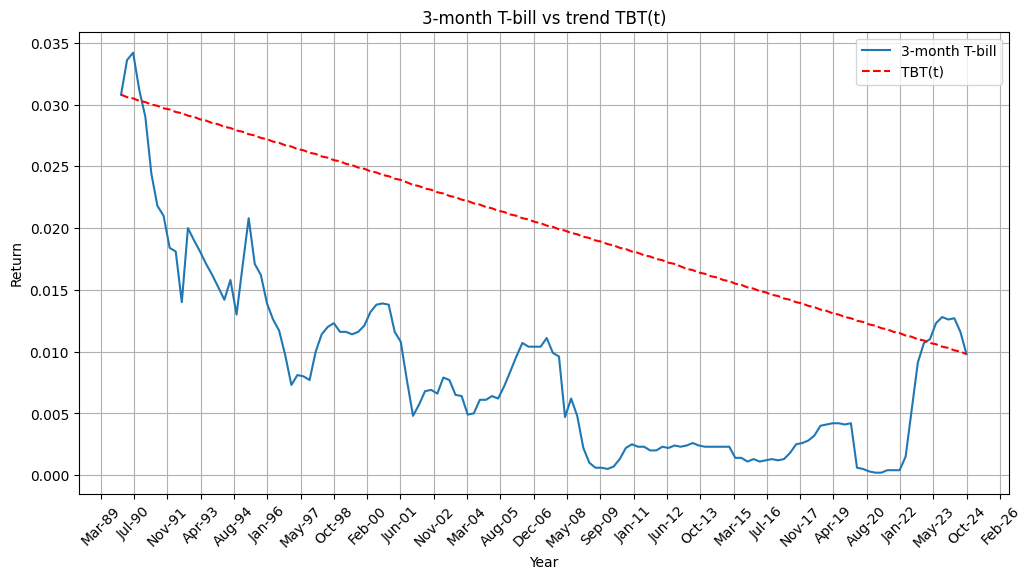

,Qtr,End of Yr,3mo TB,TSX,TBT
Date,,,,,
1990-01-01,1990Q1,0.25,0.0308,-0.0833,0.0308
1990-04-01,1990Q2,0.50,0.0336,-0.0262,0.0306
1990-07-01,1990Q3,0.75,0.0342,-0.1086,0.0305
1990-10-01,1990Q4,1.00,0.0312,0.0311,0.0303
1991-01-01,1991Q1,1.25,0.0290,0.0733,0.0302
...,...,...,...,...,...
2023-10-01,2023Q4,34.00,0.0128,0.0725,0.0104
2024-01-01,2024Q1,34.25,0.0126,0.0577,0.0103
2024-04-01,2024Q2,34.50,0.0127,-0.0131,0.0101


In [11]:

# load a copy of raw data
data = raw_data.copy()

# define a function to calculate TBT(t)
# start point
start_t = data['End of Yr'][0]
start_tb = data['3mo TB'][0]
slope_tb = (data['3mo TB'].iloc[-1] - data['3mo TB'][0]) / (data['End of Yr'].iloc[-1] - data['End of Yr'][0])

def TBT(t):
    return (start_tb + (slope_tb * (t - start_t)))

# calculate TBT(t) for each 'End of Yr' value in the data
data['TBT'] = data['End of Yr'].apply(TBT).round(4)

# Plot the 3-month T-bill and the TBT(t) over time, make the trend line for the TBT(t) a dashed line

data.dates = pd.to_datetime(data.Qtr)
data.index = data.dates
data.index.name = 'Date'

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['3mo TB'], label='3-month T-bill')
plt.plot(data.index, data['TBT'], label='TBT(t)', color='red', linestyle='--')

plt.xticks(rotation=45)

# limit the number ot ticks to 30
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))

# Format the x-axis to display the year and quarter as Mar-90, Jun-90, Sep-90, Dec-90, etc.
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b-%y'))



plt.xlabel('Year')
plt.ylabel('Return')
plt.title('3-month T-bill vs trend TBT(t)')
plt.legend()
plt.grid()
plt.show()


# display the dataframe with the new TBT column
data



### Part (a)

Add a column to the database that computes the gap betweem the actual T-bill rate and the trend TBT, that is $\text{Gap} = \text{T-bill rate}(t) - \text{TBT}(t)$. And plot the Gap variable over time

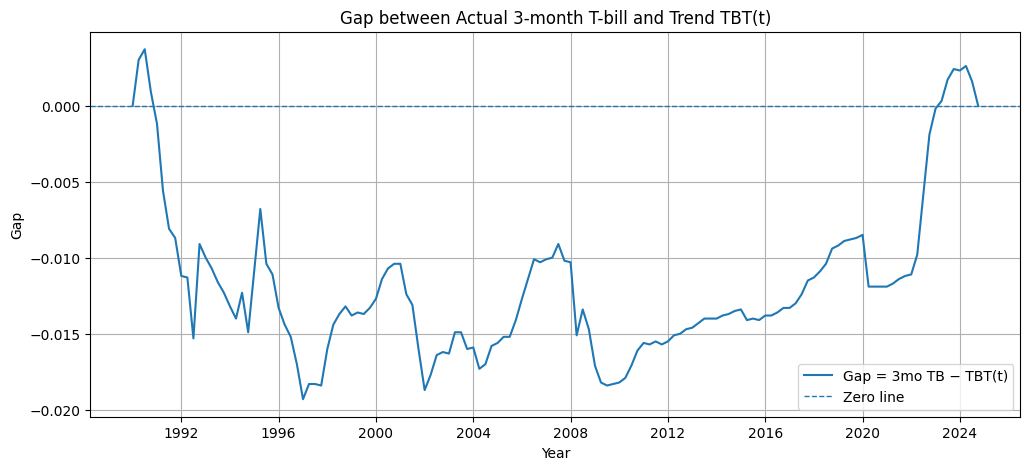

In [12]:
# Compute the Gap
data["Gap"] = (data["3mo TB"] - data["TBT"]).round(6)

# Plot the Gap over time
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Gap"], label="Gap = 3mo TB − TBT(t)")
plt.axhline(0, linewidth=1, linestyle="--", label="Zero line")
plt.title("Gap between Actual 3-month T-bill and Trend TBT(t)")
plt.xlabel("Year")
plt.ylabel("Gap")
plt.legend()
plt.grid(True)
plt.show()

### Part (b)

Suppose we can form a TAA strategy based on peaks and troughs of the Gap. This requires perfect foresight (which no one has!), but we'll use it anyway.

The logic is:

* when the Gap peaks, rates are relatively high, and we are near an economic peak. The investment strategy is to get out of stocks ($W_{c}=1$, $W_{s}=0$). We stay with this asset mix until the Gap signals a change.
* When the Gap hits a trough, we are near an economic trough. The investment strategy is to buy stocks ($W_{c}=0$, $W_{s}=1$). We stay in this asset mix until the Gap signals a change.

Assume you start the portfolio with the asset allocation: $W_{c}=1$, $W_{s}=0$ (like 1990 Q1 is a peak).

So, from the "Gap" column, we employ the following switches:

Qtr	|t  | $W_{c}$|	$W_{s}$ |
--------|--------|----|----|
1990Q1	|peak    |  1 | 0  |
1997Q1	|trough	 |	0 |	1  |
2001Q1	|peak	 |	1 |	0  |
2002Q1	|trough	 |	0 |	1  |
2007Q3	|peak	 |	1 |	0  |
2009Q4	|trough	 |	0 |	1  |
2019Q3	|peak	 |	1 |	0  |
2020Q1	|trough	 |	0 |	1  |
2023Q4  |peak    | 1  | 0  |

Add a column to the database that contains the weight $W_S$ according to the above table and compute the return ot the resulting TAA strategy,

The following code illustrates how to add a column with $W_S=1$ for a few quarters.

In [13]:
# Add a column with W_S = 0 until 1997Q1 when it switches to 1 and remain to 1 until 2001Q1 when it switches back to 0 and remain to 0 until 2002Q1 when it switches back to 1
data['W_S'] = np.where(data['Qtr'] < '1997Q1', 0, np.where(data['Qtr'] < '2001Q1', 1, np.where(data['Qtr'] < '2002Q1', 0, 1)))

# show data between 1996Q4 and 2002Q2
data[(data['Qtr'] >= '1996Q4') & (data['Qtr'] <= '2002Q2')]


,Qtr,End of Yr,3mo TB,TSX,TBT,Gap,W_S
Date,,,,,,,
1996-10-01,1996Q4,7.00,0.0097,0.1202,0.0267,-0.0170,0
1997-01-01,1997Q1,7.25,0.0073,-0.0130,0.0266,-0.0193,1
1997-04-01,1997Q2,7.50,0.0081,0.1005,0.0264,-0.0183,1
1997-07-01,1997Q3,7.75,0.0080,0.0935,0.0263,-0.0183,1
1997-10-01,1997Q4,8.00,0.0077,-0.0484,0.0261,-0.0184,1
1998-01-01,1998Q1,8.25,0.0100,0.1284,0.0260,-0.0160,1
1998-04-01,1998Q2,8.50,0.0114,-0.0254,0.0258,-0.0144,1
1998-07-01,1998Q3,8.75,0.0120,-0.2380,0.0257,-0.0137,1
1998-10-01,1998Q4,9.00,0.0123,0.1553,0.0255,-0.0132,1


What is the average return and standard deviations of return for this strategy?

In [14]:
# Define switch dates from the table
# Start in cash (Wc=1, Ws=0) at 1990Q1 (a peak)
switches = [
    ("1990Q1", 0),  # peak -> cash
    ("1997Q1", 1),  # trough -> stocks
    ("2001Q1", 0),  # peak -> cash
    ("2002Q1", 1),  # trough -> stocks
    ("2007Q3", 0),  # peak -> cash
    ("2009Q4", 1),  # trough -> stocks
    ("2019Q3", 0),  # peak -> cash
    ("2020Q1", 1),  # trough -> stocks (through sample end)
]

# Build piecewise W_S using numpy.select over Qtr string ranges
q = data["Qtr"].astype(str)

conds = [
    (q >= "1990Q1") & (q < "1997Q1"),
    (q >= "1997Q1") & (q < "2001Q1"),
    (q >= "2001Q1") & (q < "2002Q1"),
    (q >= "2002Q1") & (q < "2007Q3"),
    (q >= "2007Q3") & (q < "2009Q4"),
    (q >= "2009Q4") & (q < "2019Q3"),
    (q >= "2019Q3") & (q < "2020Q1"),
    (q >= "2020Q1"),
]
choices = [0,1,0,1,0,1,0,1]

data["W_S"] = np.select(conds, choices, default=0.0)
data["W_C"] = 1.0 - data["W_S"]

# TAA return
data["ret_TAA_gap"] = data["W_S"]*data["TSX"] + data["W_C"]*data["3mo TB"]

taa_mu, taa_sig = ann_stats(data["ret_TAA_gap"])
Ws_avg = data["W_S"].mean()

# SAA benchmark with same average stock weight
data["ret_SAA_bmk_gap"] = Ws_avg*data["TSX"] + (1.0 - Ws_avg)*data["3mo TB"]
saa_mu, saa_sig = ann_stats(data["ret_SAA_bmk_gap"])

# Result: comparison table
print(f"Comparison table (TAA vs SAA benchmark)")
out_gap = pd.DataFrame({
    "Strategy": ["TAA (Gap peaks/troughs)", f"SAA benchmark (Ws={Ws_avg:.2f})"],
    "Annualized Return": [taa_mu, saa_mu],
    "Annualized Volatility": [taa_sig, saa_sig],
    "Average Ws": [Ws_avg, Ws_avg],
})

out_gap.style.format({
    "Annualized Return": "{:.4f}",
    "Annualized Volatility": "{:.4f}",
    "Average Ws": "{:.2f}"
})


Comparison table (TAA vs SAA benchmark)


,Strategy,Annualized Return,Annualized Volatility,Average Ws
0,TAA (Gap peaks/troughs),0.0764,0.1241,0.69
1,SAA benchmark (Ws=0.69),0.0553,0.1065,0.69


### Part (c)

Calculate the average $W_{s}$ over the period, and form a SAA strategy with that constant average $W_{s}$. How does the TAA strategy reward/risk compare to the benchmark SAA strategy reward/risk?

In [15]:
# Annualized rf from the sample
rf_ann = 4 * data["3mo TB"].mean()

# Average Ws realized by the TAA timing strategy
Ws_avg = data["W_S"].mean()

# TAA (already in Part b); recreate if needed
if "ret_TAA_gap" not in data.columns:
    data["ret_TAA_gap"] = data["W_S"]*data["TSX"] + (1-data["W_S"])*data["3mo TB"]

taa_mu, taa_sig = ann_stats(data["ret_TAA_gap"])
taa_sharpe = (taa_mu - rf_ann) / taa_sig

# Benchmark SAA holding constant Ws_avg
data["ret_SAA_bmk_gap"] = Ws_avg*data["TSX"] + (1-Ws_avg)*data["3mo TB"]
saa_mu, saa_sig = ann_stats(data["ret_SAA_bmk_gap"])
saa_sharpe = (saa_mu - rf_ann) / saa_sig

# Result: Comparison table
print(f"Comparison table (TAA vs SAA benchmark)")
q4c = pd.DataFrame({
    "Strategy": ["TAA (Gap timing)", f"SAA benchmark (Ws={Ws_avg:.2f})"],
    "Annualized Return": [taa_mu, saa_mu],
    "Annualized Volatility": [taa_sig, saa_sig],
    "Sharpe (excess over T-bill)": [taa_sharpe, saa_sharpe],
    "Average Ws": [Ws_avg, Ws_avg]
})

q4c.style.format({
    "Annualized Return": "{:.4f}",
    "Annualized Volatility": "{:.4f}",
    "Sharpe (excess over T-bill)": "{:.2f}",
    "Average Ws": "{:.2f}"
})


Comparison table (TAA vs SAA benchmark)


,Strategy,Annualized Return,Annualized Volatility,Sharpe (excess over T-bill),Average Ws
0,TAA (Gap timing),0.0764,0.1241,0.34,0.69
1,SAA benchmark (Ws=0.69),0.0553,0.1065,0.20,0.69


* The TAA strategy achieves **higher annualized returns** than the SAA benchmark. This is because TAA shifts into stocks during economic troughs and moves into cash during peak periods, avoiding some negative stock market episodes. The strategy relies on perfect foresight of turning points, and its performance reflects an idealized upper bound on what timing could achieve.
* TAA has slightly **higher volatility** (12.41% vs. 10.65%) than the constant-weight SAA strategy. By allocating to cash during peak periods, TAA avoids exposure to large downturns and unstable conditions, though it still incurs some volatility. However, its Sharpe ratio is much higher (0.34 vs. 0.20), showing that the additional risk is compensated by higher excess returns.
* The TAA strategy outperforms the SAA benchmark with **better risk-adjusted performance**, showing the significance of effective timing. However, this advantage exists only because the TAA strategy assumes perfect foresight of economic peaks and troughs, which might not be realistic in practice.

## **Section 3: IAA**

### Question 5

Here we examine the simplest variant of an IAA strategy, CPPI (Constant Proportion Portfolio Insurance). We show the implementation of IAA strategy on the dataset `raw_data`.  The inputs for the CPPI strategy are the multiplier, $m$, the floor, $F$, and the starting wealth level, $V_{0}$.

Consider a CPPI strategy with $V_{0}=1000$, $F=1000$ and $m=2$.  The following code shows how to implement this IAA strategy on the database `raw_data`

In [17]:

# load a copy of raw data
data = raw_data.copy()

# Initialize parameters
V0 = 1000  # initial wealth
m = 2      # multiplier
F = 1000  # Floor

# Initialize variables
Ws = []  # weight in stock index
portfolio_values = [V0]

# Calculate the initial stock proportion (Ws0)
cushion_initial = V0 - F
Ws0 = m * cushion_initial / V0  # Shorting allowed, so no need to check for cushion_initial > 0
Ws.append(Ws0)

# Calculate the portfolio value for the first period using Ws0
portfolio_value_first_period = V0 * (1 + Ws0 * data['TSX'].iloc[0] + (1 - Ws0) * data['3mo TB'].iloc[0])
portfolio_values.append(portfolio_value_first_period)

# Apply the CPPI strategy for the remaining periods
for i in range(1, len(data)):
    cushion = portfolio_values[-1] - F
    ws = m * cushion / portfolio_values[-1]  # Shorting allowed
    Ws.append(ws)

    # Update portfolio value
    portfolio_value = portfolio_values[-1] * (1 + ws * data['TSX'].iloc[i] + (1 - ws) * data['3mo TB'].iloc[i])
    portfolio_values.append(portfolio_value)



# Add the Ws and portfolio values to the data
data['Ws'] = Ws
data['Portfolio Value (end or period)'] = portfolio_values[1:]  # Skip the initial value

data.round(4)



,Qtr,End of Yr,3mo TB,TSX,Ws,Portfolio Value (end or period)
0,1990Q1,0.25,0.0308,-0.0833,0.0000,1030.8000
1,1990Q2,0.50,0.0336,-0.0262,0.0598,1061.7512
2,1990Q3,0.75,0.0342,-0.1086,0.1163,1080.4269
3,1990Q4,1.00,0.0312,0.0311,0.1489,1114.1202
4,1991Q1,1.25,0.0290,0.0733,0.2049,1156.5407
...,...,...,...,...,...,...
135,2023Q4,34.00,0.0128,0.0725,1.5614,5043.2748
136,2024Q1,34.25,0.0126,0.0577,1.6034,5471.5235
137,2024Q2,34.50,0.0127,-0.0131,1.6345,5310.2812
138,2024Q3,34.75,0.0116,0.0971,1.6234,6108.9385


### Part (a)

Calculate the following quantities under this IAA strategy:

* The average annualized portfolio return
* The portfolio annualized standard deviation of return
* The ending wealth level, $V$
* The average stock proportion
* The initial stock proportion, $W_{s0}$

In [18]:
V0 = 1000.0        # Initial wealth
F  = 1000.0        # Floor
m  = 2.0           # Multiplier

df = raw_data.copy().reset_index(drop=True)

# CPPI strategy

V = [V0]          # list for wealth values (starts at V0)
Ws = []           # stock weights each quarter
r_cppi = []       # CPPI returns

# Initial quarter (t = 0)
cushion0 = V0 - F
Ws0 = m * cushion0 / V0            # shorting allowed
Ws.append(Ws0)

# First return
r0 = Ws0 * df.loc[0, "TSX"] + (1 - Ws0) * df.loc[0, "3mo TB"]
V_first = V0 * (1 + r0)

V.append(V_first)
r_cppi.append(r0)

# Remaining quarters
for t in range(1, len(df)):
    cushion = V[-1] - F
    ws = m * cushion / V[-1]       # no constraint (shorting allowed)
    Ws.append(ws)

    rt = ws * df.loc[t, "TSX"] + (1 - ws) * df.loc[t, "3mo TB"]
    r_cppi.append(rt)

    V_new = V[-1] * (1 + rt)
    V.append(V_new)

# Align lists with DataFrame
df["Ws"] = Ws
df["r_CPPI"] = r_cppi
df["V_end"] = V[1:]        # skip initial V0


# 5 required quantities

# 1) Average annualized portfolio return
avg_ann_return = 4 * df["r_CPPI"].mean()

# 2) Annualized portfolio standard deviation
ann_volatility = (4**0.5) * df["r_CPPI"].std()

# 3) Ending wealth level
ending_wealth = df["V_end"].iloc[-1]

# 4) Average stock proportion
avg_Ws = df["Ws"].mean()

# 5) Initial stock proportion W_s0
initial_Ws0 = Ws0

# Results
iaa_results = pd.DataFrame({
    "Metric": [
        "Average annualized portfolio return",
        "Annualized standard deviation",
        "Ending wealth level (V)",
        "Average stock proportion",
        "Initial stock proportion W_s0"
    ],
    "Value": [
        avg_ann_return,
        ann_volatility,
        ending_wealth,
        avg_Ws,
        initial_Ws0
    ]
})

print("CPPI (IAA) Part(a) Results")
# Display with formatting
iaa_results.style.format({
    "Value": "{:.4f}"
})


CPPI (IAA) Part(a) Results


,Metric,Value
0,Average annualized portfolio return,0.0733
1,Annualized standard deviation,0.1921
2,Ending wealth level (V),6378.2726
3,Average stock proportion,1.1648
4,Initial stock proportion W_s0,0.0000


### Part (b)

Repeat the test in Part (a) with the different values of $F$ listed below. All scenarios have the same $V_{0}=1000$ and $m=2$.

Scenario | F |
---------|--|
1        |2000|
2        |3000|
3        |4000|
4        |5000|

What happens as you raise $F$? That is, what changes in the results? Explain briefly.

Ideally, you need prepare the following dimensions for each $F$, and you comment the results when $F$ changes.

F | Ws0 | Average $W_{s}$ | Average annualized portfolio return | Annualized portfolio standard deviation | Ending wealth|
--|-----|-----------------|-------------------------------------|-----------------------------------------|--------------|
2000 |  |                 |                                     |                                         |              |
3000 |  |                 |                                     |                                         |              |
4000 |  |                 |                                     |                                         |              |
5000 |  |                 |                                     |                                         |              |




In [19]:
def run_cppi_metrics(df_in, V0=1000.0, F=1000.0, m=2.0, allow_shorting=True):
    """Run CPPI and return metrics for Part (a)/(b)."""
    df = df_in.copy().reset_index(drop=True)
    V = [V0]
    Ws = []
    r_cppi = []

    # t=0
    cushion0 = V0 - F
    ws0 = m * cushion0 / V0
    if not allow_shorting:
        ws0 = max(0.0, min(1.0, ws0))
    Ws.append(ws0)

    r0 = ws0 * df.loc[0, "TSX"] + (1 - ws0) * df.loc[0, "3mo TB"]
    V.append(V0 * (1 + r0))
    r_cppi.append(r0)

    # t=1..T-1
    for t in range(1, len(df)):
        cushion = V[-1] - F
        ws = m * cushion / V[-1]
        if not allow_shorting:
            ws = max(0.0, min(1.0, ws))
        Ws.append(ws)

        rt = ws * df.loc[t, "TSX"] + (1 - ws) * df.loc[t, "3mo TB"]
        r_cppi.append(rt)
        V.append(V[-1] * (1 + rt))

    # Metrics (annualization)
    avg_ann_return = 4 * np.mean(r_cppi)
    ann_vol = (4**0.5) * np.std(r_cppi, ddof=1)
    ending_wealth = V[-1]
    avg_Ws = np.mean(Ws)
    return {
        "Ws0": ws0,
        "Average Ws": avg_Ws,
        "Average annualized portfolio return": avg_ann_return,
        "Annualized portfolio standard deviation": ann_vol,
        "Ending wealth": ending_wealth,
    }

# Floors to test (shorting allowed, as in your notebook)
floors = [2000, 3000, 4000, 5000]
rows = []
for F in floors:
    metrics = run_cppi_metrics(raw_data, V0=1000.0, F=F, m=2.0, allow_shorting=True)
    rows.append({"F": F, **metrics})

# Result
cppi_b = pd.DataFrame(rows)[[
    "F", "Ws0", "Average Ws",
    "Average annualized portfolio return",
    "Annualized portfolio standard deviation",
    "Ending wealth"
]]

print("CPPI (IAA) Part (b): Results across floors F (shorting allowed)")
cppi_b.style.format({
    "F": "{:,.0f}",
    "Ws0": "{:.2f}",
    "Average Ws": "{:.2f}",
    "Average annualized portfolio return": "{:.4f}",
    "Annualized portfolio standard deviation": "{:.4f}",
    "Ending wealth": "{:,.2f}",
})


CPPI (IAA) Part (b): Results across floors F (shorting allowed)


,F,Ws0,Average Ws,Average annualized portfolio return,Annualized portfolio standard deviation,Ending wealth
0,"2,000",-2.00,0.82,0.0737,0.1566,"8,268.64"
1,"3,000",-4.00,0.62,0.0784,0.1554,"10,159.01"
2,"4,000",-6.00,0.49,0.0845,0.1724,"12,049.38"
3,"5,000",-8.00,0.40,0.0910,0.1987,"13,939.75"


As the floor 𝐹 increases, the CPPI strategy becomes increasingly constrained, because the cushion 𝑉𝑡−𝐹 shrinks and often becomes negative. Since shorting is allowed, a higher floor forces the portfolio to take larger short positions in equities.

The initial stock proportion (Ws0) becomes more negative as 𝐹 rises, and the average stock exposure over time decreases. Both the annualized return and ending wealth increase with higher floors, and the annualized volatility also rises since leveraged short positions amplify risk.

This increasing reliance on short-equity positions leads to higher realized returns but also greater volatility as 𝐹 increases (higher floor constraint).

### Part (c)

Consider another set of scenarios where the original parameters of $V=1000$ and $F=1000$. But we vary $m$ as follows:

Scenario | m|
---------|--|
1        |0|
2        |1|
3        |2|
4        |3|

What happens as you raise $m$? That is, what changes in the table of results? Explain briefly.

Ideally, you need fill the following table for each $m$ and comment on the results when $m$ changes.

m | Ws0 | Average $W_{s}$ | Average annualized portfolio return | Annualized portfolio standard deviation | Ending wealth|
--|-----|-----------------|-------------------------------------|-----------------------------------------|--------------|
0 |  |                 |                                     |                                         |              |
1 |  |                 |                                     |                                         |              |
2 |  |                 |                                     |                                         |              |
3 |  |                 |                                     |                                         |              |



In [20]:
def run_cppi_metrics(df_in, V0=1000.0, F=1000.0, m=2.0, allow_shorting=True):
    df = df_in.copy().reset_index(drop=True)
    V = [V0]
    Ws = []
    r_cppi = []

    # t=0 (note: with V0=F, cushion0 = 0 → Ws0 = 0 for any m)
    cushion0 = V0 - F
    ws0 = m * cushion0 / V0
    if not allow_shorting:
        ws0 = max(0.0, min(1.0, ws0))
    Ws.append(ws0)

    r0 = ws0 * df.loc[0, "TSX"] + (1 - ws0) * df.loc[0, "3mo TB"]
    V.append(V0 * (1 + r0))
    r_cppi.append(r0)

    # t = 1..T-1
    for t in range(1, len(df)):
        cushion = V[-1] - F
        ws = m * cushion / V[-1]
        if not allow_shorting:
            ws = max(0.0, min(1.0, ws))
        Ws.append(ws)

        rt = ws * df.loc[t, "TSX"] + (1 - ws) * df.loc[t, "3mo TB"]
        r_cppi.append(rt)
        V.append(V[-1] * (1 + rt))

    # Annualization
    avg_ann_return = 4 * np.mean(r_cppi)
    ann_vol = (4**0.5) * np.std(r_cppi, ddof=1)
    ending_wealth = V[-1]
    avg_Ws = np.mean(Ws)

    return {
        "Ws0": ws0,
        "Average Ws": avg_Ws,
        "Average annualized portfolio return": avg_ann_return,
        "Annualized portfolio standard deviation": ann_vol,
        "Ending wealth": ending_wealth,
    }

m_list = [0, 1, 2, 3]
rows = []
for m in m_list:
    metrics = run_cppi_metrics(raw_data, V0=1000.0, F=1000.0, m=m, allow_shorting=True)
    rows.append({"m": m, **metrics})

q5c_m = pd.DataFrame(rows)[[
    "m", "Ws0", "Average Ws",
    "Average annualized portfolio return",
    "Annualized portfolio standard deviation",
    "Ending wealth"
]]

print("CPPI (IAA) Part (c): Results across multipliers m (shorting allowed, V0=F=1000)")
q5c_m.style.format({
    "m": "{:.0f}",
    "Ws0": "{:.2f}",
    "Average Ws": "{:.2f}",
    "Average annualized portfolio return": "{:.4f}",
    "Annualized portfolio standard deviation": "{:.4f}",
    "Ending wealth": "{:,.2f}",
})


CPPI (IAA) Part (c): Results across multipliers m (shorting allowed, V0=F=1000)


,m,Ws0,Average Ws,Average annualized portfolio return,Annualized portfolio standard deviation,Ending wealth
0,0,0.00,0.00,0.0337,0.0146,"3,230.07"
1,1,0.00,0.60,0.0569,0.0972,"6,106.25"
2,2,0.00,1.16,0.0733,0.1921,"6,378.27"
3,3,0.00,1.32,0.0619,0.2321,"2,915.55"


As we increase the CPPI multiplier 𝑚, the strategy becomes more aggressive. Because the initial wealth equals the floor ($V0=F=1000$), the initial stock weight is always zero, regardless of 𝑚. However, as soon as the portfolio value moves away from the floor, the equity allocation becomes $Ws(t)=m\frac{Vt-F}{Vt}$, meaning that a higher multiplier amplifies the size of both long and short positions.

This leads to higher average stock weights, higher volatility, and typically higher returns and ending wealth, since the strategy takes on more market risk.

* From m = 0 to m = 2, higher stock exposure raises both annualized return (0.0337 → 0.0733) and volatility (0.0146 → 0.1921), and ending wealth also increases.

* However, at m = 3, the portfolio becomes too leveraged, so volatility jumps again while return actually falls and ending wealth drops dramatically.

Overall, raising 𝑚 increases both risk and upside potential, but beyond a certain point, the strategy becomes excessively volatile, leading to worse performance despite high stock weight.

## **Part II: Style Investment**

In this part, we will use data from BlackRock ETF and from the Fama-French Factors to understand the style of some of BlackRock ETFs

### Question 6

The following code loads monthly rerturn data for the following ETFs:


(1). BlackRock iShares MSCI USA Value Factor ETF

(2). BlackRock iShares MSCI USA Size Factor ETF

(3). BlackRock iShares MSCI USA Quality Factor ETF

(4). BlackRock iShares MSCI USA Momentum Factor ETF

(5). BlackRock iShares Min Volatility Factor ETF

Regress the ETF returns of all the BlackRock ETF on Fama-French 4 factors and report the regression results in an aggregated table. Based on the results of your analysis provide a short comment on the coefficients you find for each of the Factor ETFs. For example, does the Value ETF loads more on the value factor than other ETFs, etc.?

Note: If you want to understand more about these ETFs, e.g. product fact sheets, you can go to the following websites:

* Value ETF: https://www.blackrock.com/us/individual/products/251616/ishares-msci-usa-value-factor-etf
* Size ETF: https://www.blackrock.com/us/individual/products/251465/ishares-msci-usa-size-factor-etf
* Quality ETF: https://www.blackrock.com/us/individual/products/256101/ishares-msci-usa-quality-factor-etf
* Momentum ETF: https://www.blackrock.com/us/individual/products/251614/ishares-msci-usa-momentum-factor-etf
* Volatility ETF: https://www.blackrock.com/us/individual/products/239695/ishares-msci-usa-minimum-volatility-etf

### Data and preliminary functions

In [21]:
# # load blackrock ETF data from github
import urllib.request
import ssl

# load blackrock ETF data from github
csv_etfs = 'https://raw.githubusercontent.com/BillTilford/COMM475/main/blackrock_ishares_factor_ETF_returns.csv'
with urllib.request.urlopen(csv_etfs, context=ctx) as u:
    etf_data = pd.read_csv(u)

# transform ETF returns from percentages to fractions
etf_data.iloc[:, 1:] = etf_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') / 100

etf_data.head(3)

,Month End Date,Value Factor ETF,Size Factor ETF,Quality Factor ETF,Momentum Factor ETF,Min Vol Factor ETF
0,30-Apr-13,NaN,NaN,NaN,NaN,0.0272
1,31-May-13,0.0311,0.0002,NaN,-0.0008,-0.0244
2,30-Jun-13,-0.0134,-0.0044,NaN,-0.0095,-0.0033


The following code merges BlackRock ETF returns data with the Fama-Fremch 4 Factors: .

In [22]:
# merge blackrock ETF returns data and the Fama-French 4 factors

# format date column in the ETF data to add the year and month columns
etf_data.rename(columns={'Month End Date': 'date'}, inplace=True)
etf_data['date'] = pd.to_datetime(etf_data['date'], format='%d-%b-%y')
etf_data['year'] = etf_data['date'].dt.year
etf_data['month'] = etf_data['date'].dt.month

# format date column in the Fama-French factors data to add the year and month columns
ff4_factors_monthly['date'] = pd.to_datetime(ff4_factors_monthly['date'], format='%Y%m', errors='coerce')
ff4_factors_monthly['year'] = ff4_factors_monthly['date'].dt.year
ff4_factors_monthly['month'] = ff4_factors_monthly['date'].dt.month

# merge the ETF data and the Fama-French factors data by year and month
merged_data = pd.merge(etf_data, ff4_factors_monthly, on=['year', 'month'], how='left')
# drop duplicated date column
merged_data = merged_data.drop(columns=['date_y'])
# rename the date column
merged_data.rename(columns={'date_x': 'date'}, inplace=True)
# drop NA
merged_data = merged_data.dropna(axis=0, how='any').reset_index(drop=True)


The following function performs multiple regressions for the Value Factor ETF on the Fama-French factors...repeat for the other ETFs

In [23]:
def multiple_regression(X,Y):
    # Add a constant to X
    X = sm.add_constant(X)

    # Replace NaN values with the mean of the column
    X = X.fillna(X.mean())
    Y = Y.fillna(Y.mean())

    # Fit and summarize OLS model
    results = sm.OLS(Y, X).fit()
    return results

# Instructions on how to run regressions:
# To run a regresson of the returns on Value Factor ETF on the returns on FF factors, we can use the following commands:
X = merged_data[['mkt_excess', 'smb', 'hml', 'mom']]
Y = merged_data['Value Factor ETF'].apply(pd.to_numeric, errors='coerce')
results = multiple_regression(X,Y)

# To see the resujlts, type
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Value Factor ETF   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     491.0
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           1.41e-78
Time:                        01:04:17   Log-Likelihood:                 411.33
No. Observations:                 138   AIC:                            -812.7
Df Residuals:                     133   BIC:                            -798.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.731      0.466      -0.003       0.001
mkt_excess     0.9785      0.027     36.056      0.000       0.925       1.032
smb            0.0454      0.042      1.085      0.280      -0.037       0.128
hml            0.3981      0.031     12.669      0.000       0.336       0.460
mom           -0.0741      0.033     -2.252      0.026      -0.139      -0.009
==============================================================================
Omnibus:                        2.007   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.367   Jarque-Bera (JB):                1.550
Skew:                          -0.158   Prob(JB):                        0.461
Kurtosis:                       3.412   Cond. No.                         40.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# ETF return columns
etf_cols = [
    'Value Factor ETF',
    'Size Factor ETF',
    'Quality Factor ETF',
    'Momentum Factor ETF',
    'Min Vol Factor ETF'
]

# Fama–French factor matrix
X = merged_data[['mkt_excess', 'smb', 'hml', 'mom']].copy()
X = sm.add_constant(X)

rows = []

for etf in etf_cols:
    y = pd.to_numeric(merged_data[etf], errors='coerce')
    ok = y.notna()

    model = sm.OLS(y[ok], X.loc[ok]).fit()

    rows.append({
        'ETF'   : etf,
        'alpha' : model.params['const'],
        'mkt'   : model.params['mkt_excess'],
        'smb'   : model.params['smb'],
        'hml'   : model.params['hml'],
        'mom'   : model.params['mom'],
        't(alpha)': model.tvalues['const'],
        't(mkt)'  : model.tvalues['mkt_excess'],
        't(smb)'  : model.tvalues['smb'],
        't(hml)'  : model.tvalues['hml'],
        't(mom)'  : model.tvalues['mom'],
        'R2'      : model.rsquared
    })

results = pd.DataFrame(rows)

# Regression table

def fmt_coef(c, t):
    return f"{c:.3f}\n({t:.2f})"

pretty = results.copy()
pretty['alpha'] = [fmt_coef(a,t) for a,t in zip(results['alpha'], results['t(alpha)'])]
pretty['mkt']   = [fmt_coef(a,t) for a,t in zip(results['mkt'],   results['t(mkt)'])]
pretty['smb']   = [fmt_coef(a,t) for a,t in zip(results['smb'],   results['t(smb)'])]
pretty['hml']   = [fmt_coef(a,t) for a,t in zip(results['hml'],   results['t(hml)'])]
pretty['mom']   = [fmt_coef(a,t) for a,t in zip(results['mom'],   results['t(mom)'])]
pretty['R2']    = pretty['R2'].map(lambda x: f"{x:.3f}")


print("Regression result")
display(results.set_index('ETF').round(4))



Regression result


,alpha,mkt,smb,hml,mom,t(alpha),t(mkt),t(smb),t(hml),t(mom),R2
ETF,,,,,,,,,,,
Value Factor ETF,-0.0008,0.9785,0.0454,0.3981,-0.0741,-0.7311,36.0562,1.0852,12.6694,-2.2515,0.9366
Size Factor ETF,0.0004,0.9891,0.0849,0.1615,-0.0267,0.4514,45.1468,2.5125,6.3680,-1.0061,0.9535
Quality Factor ETF,0.0010,0.9966,-0.1821,-0.0487,-0.0152,1.4203,55.9903,-6.6299,-2.3654,-0.7063,0.9652
Momentum Factor ETF,0.0002,1.0562,-0.0745,-0.0615,0.3904,0.1278,34.6344,-1.5821,-1.7403,10.5624,0.9043
Min Vol Factor ETF,0.0009,0.7822,-0.2101,0.0447,0.1199,0.7012,24.8286,-4.3215,1.2242,3.1405,0.8307


Each BlackRock factor ETF exhibits the expected style exposures.
* The Value Factor ETF shows a strong positive loading on the HML factor, indicating clear value exposure that is larger than any other ETF in the sample.
* The Size Factor ETF loads most heavily on the SMB factor, confirming that it captures small-cap characteristics, with only moderate exposure to value.
* The Quality Factor ETF displays negative loadings on both SMB and HML, meaning it behaves more like a large-cap growth portfolio, which fits the typical profile of high-quality firms.
* The Momentum Factor ETF exhibits the highest positive loading on the MOM factor, confirming it is a pure momentum strategy, while also showing slight negative size and value exposure, consistent with momentum’s usual tilt toward large-cap growth stocks.
* The Min Vol Factor ETF has the lowest market beta and a strong negative SMB coefficient, reflecting its defensive, large-cap characteristics.

Overall, the factor loadings align well with the intended style of each ETF, and the regression results validate that each fund behaves consistently with its factor label.